# Datalabframework

The datalabframework is a productivity framework for ETL, ML application. Simplifying some of the common activities which are typical in Data pipeline such as project scaffolding, data ingesting, start schema generation, forecasting etc.

In [2]:
import datalabframework as dlf

## Loading and Saving Data

In [3]:
dlf.project.load()

created SparkEngine
Init engine "spark"
Configuring packages:
  -  com.microsoft.sqlserver:mssql-jdbc:6.4.0.jre8
  -  mysql:mysql-connector-java:8.0.12
  -  org.apache.hadoop:hadoop-aws:3.1.1
  -  org.postgresql:postgresql:42.2.5
Configuring conf:
  -  spark.hadoop.fs.s3a.access.key : ****** (redacted)
  -  spark.hadoop.fs.s3a.endpoint : http://minio:9000
  -  spark.hadoop.fs.s3a.impl : org.apache.hadoop.fs.s3a.S3AFileSystem
  -  spark.hadoop.fs.s3a.path.style.access : true
  -  spark.hadoop.fs.s3a.secret.key : ****** (redacted)
Connecting to spark master: local[*]
Engine context spark:2.4.1 successfully started


In [4]:
def equal(a,b):
    cnt = a.exceptAll(b).count() + b.exceptAll(a).count()
    return cnt==0

### Local files

The following show some load/save round trip on the local file system using various formats

In [5]:
#read data
df = dlf.engine().load('data/examples/sample.csv')
df.show()

+---+---+----+
|  a|  b|   c|
+---+---+----+
|yes|  1|1.41|
| no|  0|3.14|
+---+---+----+



In [6]:
# save in various format
dlf.save(df, 'data/save/foo.csv')
dlf.save(df, 'data/save/foo.json')
dlf.save(df, 'data/save/foo.parquet')

# with various compression
dlf.save(df, 'data/save/foo.json.bz2')
dlf.save(df, 'data/save/foo.csv.gz')

True

In [7]:
# using format specific save

dlf.save(df, 'data/save/bar.1', format='csv')
dlf.save(df, 'data/save/bar.2', format='json')
dlf.save(df, 'data/save/bar.3', format='parquet')

# with various compression
dlf.save(df, 'data/save/bar.4', format='csv', compression='bzip2')
dlf.save(df, 'data/save/bar.5', format='json', compression='gzip')
dlf.save(df, 'data/save/bar.6', format='parquet', compression='gzip')
dlf.save(df, 'data/save/bar.7', format='parquet', compression='snappy')

True

In [8]:
# round trip reading
df_tst = dlf.load('data/save/foo.csv')
assert(equal(df,df_tst))

df_tst = dlf.load('data/save/foo.json')
assert(equal(df,df_tst))

df_tst = dlf.load('data/save/foo.parquet')
assert(equal(df,df_tst))

df_tst = dlf.load('data/save/foo.json.bz2')
assert(equal(df,df_tst))

df_tst = dlf.load('data/save/foo.csv.gz')
assert(equal(df,df_tst))


In [9]:
# round trip reading (format specific load)
df_tst = dlf.load('data/save/bar.1', format='csv')
assert(equal(df,df_tst))

df_tst = dlf.load('data/save/bar.2', format='json')
assert(equal(df,df_tst))

df_tst = dlf.load('data/save/bar.3', format='parquet')
assert(equal(df,df_tst))

# df_tst = dlf.load('data/save/bar.4', format='csv', compression='bzip2')
# assert(equal(df,df_tst))

# df_tst = dlf.load('data/save/bar.5', format='json', compression='gzip')
# assert(equal(df,df_tst))

df_tst = dlf.load('data/save/bar.6', format='parquet', compression='gzip')
assert(equal(df,df_tst))

df_tst = dlf.load('data/save/bar.7', format='parquet', compression='snappy')
assert(equal(df,df_tst))


### Access data from HDFS

We can override the default resource provider, 
by explicitely passing a different provider

In [10]:
dlf.save(df, 'data/examples/bar.csv', 'hdfs')
dlf.save(df, 'data/examples/bar.json', 'hdfs')
dlf.save(df, 'data/examples/bar.parquet', 'hdfs')

True

In [11]:
df_tst = dlf.load('data/examples/bar.csv', 'hdfs')
assert(equal(df,df_tst))

df_tst = dlf.load('data/examples/bar.json', 'hdfs')
assert(equal(df,df_tst))

df_tst = dlf.load('data/examples/bar.parquet', 'hdfs')
assert(equal(df,df_tst))

### Access data from Minio

We can override the default resource provider, 
by explicitely passing a different provider

In [12]:
dlf.save(df, 'data/examples/bar.csv', 'minio')
dlf.save(df, 'data/examples/bar.json', 'minio')
dlf.save(df, 'data/examples/bar.parquet', 'minio')

True

In [13]:
df_tst = dlf.load('data/examples/bar.csv', 'minio')
assert(equal(df,df_tst))

df_tst = dlf.load('data/examples/bar.json', 'minio')
assert(equal(df,df_tst))

df_tst = dlf.load('data/examples/bar.parquet', 'minio')
assert(equal(df,df_tst))

### Access data from Web (HTTP/HTTPS)

Files from web will be first downloaded locally on the driver, then passed to spark ...

In [15]:
df_tst = dlf.load('https://raw.githubusercontent.com/natbusa/dlf-tutorial/master/data/examples/sample.csv')
assert(equal(df,df_tst))

Downloaded 27 bytes


### Access data from a Database (via jdbc connection)

#### MySQL: Sakila DB

In [16]:
query = """
    SELECT c.last_name,
        COUNT(p.amount) AS amount
    FROM customer c
    LEFT JOIN payment p
        ON c.customer_id = p.customer_id
    WHERE c.last_name like 'A%'
    GROUP BY  c.last_name
    ORDER BY  c.last_name ASC
    LIMIT 10;
"""
dlf.load(query, 'sakila').show()

+---------+------+
|last_name|amount|
+---------+------+
|    ABNEY|    21|
|     ADAM|    28|
|    ADAMS|    27|
|ALEXANDER|    27|
|   ALLARD|    32|
|    ALLEN|    31|
|  ALVAREZ|    27|
| ANDERSON|    24|
|   ANDREW|    25|
|  ANDREWS|    23|
+---------+------+



In [17]:
df = dlf.load('customer', 'sakila')
df.select('customer_id', 'store_id', 'first_name', 'last_name').show(10)

+-----------+--------+----------+---------+
|customer_id|store_id|first_name|last_name|
+-----------+--------+----------+---------+
|          1|       1|      MARY|    SMITH|
|          2|       1|  PATRICIA|  JOHNSON|
|          3|       1|     LINDA| WILLIAMS|
|          4|       2|   BARBARA|    JONES|
|          5|       1| ELIZABETH|    BROWN|
|          6|       2|  JENNIFER|    DAVIS|
|          7|       1|     MARIA|   MILLER|
|          8|       2|     SUSAN|   WILSON|
|          9|       2|  MARGARET|    MOORE|
|         10|       1|   DOROTHY|   TAYLOR|
+-----------+--------+----------+---------+
only showing top 10 rows



#### Postgres: Pagila DB

In [18]:
# query from resource
md = dlf.Resource('select CAST(sum(amount) as DECIMAL(8,2)), customer_id from payment group by customer_id', 'pagila')
dlf.load(md).show(5)

+------+-----------+
|   sum|customer_id|
+------+-----------+
| 90.77|        184|
|145.70|         87|
|109.78|        477|
|157.65|        273|
|159.68|        550|
+------+-----------+
only showing top 5 rows



In [19]:
#Use JOIN to display the total amount rung up by each staff member
# use tables 'staff' and 'payment'

query = """
    SELECT 
        CAST(SUM(p.amount) AS DECIMAL(16,2)) as total_sales, 
        s.last_name, 
        s.first_name
    FROM payment p 
    INNER JOIN staff s ON p.staff_id = s.staff_id 
    GROUP BY s.last_name, s.first_name
    """
df = dlf.load(query, 'pagila')
df.show()

+-----------+---------+----------+
|total_sales|last_name|first_name|
+-----------+---------+----------+
|   33489.47|  Hillyer|      Mike|
|   33927.04| Stephens|       Jon|
+-----------+---------+----------+



In [20]:
md = dlf.Resource('total_sales', 'pagila')
dlf.save(df, md)

True

In [21]:
# round trip read back
dlf.load('total_sales', 'pagila').show()

+-----------+---------+----------+
|total_sales|last_name|first_name|
+-----------+---------+----------+
|   33489.47|  Hillyer|      Mike|
|   33927.04| Stephens|       Jon|
+-----------+---------+----------+



In [22]:
# check if the pyspark DataFrame class is monkey patched
df.datalabframework()

datalabframework 0.8.2


In [23]:
# generate a new dataframe from the original one, 
# by providing new data and retaining the original schema

from decimal import Decimal as d
df = df.rows.overwrite([(d(12345.67),'Dereck', 'Eve')])
df.show()

+-----------+---------+----------+
|total_sales|last_name|first_name|
+-----------+---------+----------+
|   12345.67|   Dereck|       Eve|
+-----------+---------+----------+



In [24]:
# append new records and reload
dlf.save(df, 'total_sales', 'pagila', mode='append')
dlf.load('total_sales', 'pagila').show()

+-----------+---------+----------+
|total_sales|last_name|first_name|
+-----------+---------+----------+
|   33489.47|  Hillyer|      Mike|
|   33927.04| Stephens|       Jon|
|   12345.67|   Dereck|       Eve|
+-----------+---------+----------+



### From one provider to the other

In [25]:
dlf.load('payment', 'pagila').save('data/payment', 'hdfs')

True

### Use a better show :)

In [36]:
import datalabframework as dlf
dlf.project.load()

Init engine "spark"
Configuring packages:
  -  com.microsoft.sqlserver:mssql-jdbc:6.4.0.jre8
  -  mysql:mysql-connector-java:8.0.12
  -  org.apache.hadoop:hadoop-aws:3.1.1
  -  org.postgresql:postgresql:42.2.5
Configuring conf:
  -  spark.hadoop.fs.s3a.access.key : ****** (redacted)
  -  spark.hadoop.fs.s3a.endpoint : http://minio:9000
  -  spark.hadoop.fs.s3a.impl : org.apache.hadoop.fs.s3a.S3AFileSystem
  -  spark.hadoop.fs.s3a.path.style.access : true
  -  spark.hadoop.fs.s3a.secret.key : ****** (redacted)
Connecting to spark master: local[*]
Engine context spark:2.4.1 successfully started


In [37]:
query = """
    SELECT 
        p.payment_date,
        p.amount,
        p.rental_id,
        p.staff_id,
        c.*
    FROM payment p 
    INNER JOIN customer c 
        ON p.customer_id = c.customer_id;
    """

df = dlf.load(query, 'pagila')

In [38]:
dlf.load(query, 'pagila').save('temp', 'pagila')

True

In [39]:
df = df.cols.find('name', 'email').lower()

In [40]:
df.data.grid()

AttributeError: 'DataFrame' object has no attribute 'data'

In [6]:
html = 

,payment_date,amount,rental_id,staff_id,customer_id,store_id,first_name,last_name,email,address_id,activebool,create_date,last_update,active
0,2007-01-24 21:40:19.996577,1.99,7,2,269,1,CASSANDRA,WALTERS,CASSANDRA.WALTERS@sakilacustomer.org,274,True,2006-02-14,2006-02-15 09:57:20,1
1,2007-01-25 15:16:50.996577,0.99,98,1,269,1,CASSANDRA,WALTERS,CASSANDRA.WALTERS@sakilacustomer.org,274,True,2006-02-14,2006-02-15 09:57:20,1
2,2007-01-28 21:44:14.996577,6.99,678,2,269,1,CASSANDRA,WALTERS,CASSANDRA.WALTERS@sakilacustomer.org,274,True,2006-02-14,2006-02-15 09:57:20,1
3,2007-01-29 00:58:02.996577,0.99,703,2,269,1,CASSANDRA,WALTERS,CASSANDRA.WALTERS@sakilacustomer.org,274,True,2006-02-14,2006-02-15 09:57:20,1
4,2007-01-29 08:10:06.996577,4.99,750,1,269,1,CASSANDRA,WALTERS,CASSANDRA.WALTERS@sakilacustomer.org,274,True,2006-02-14,2006-02-15 09:57:20,1
5,2007-01-31 12:23:14.996577,2.99,1099,2,269,1,CASSANDRA,WALTERS,CASSANDRA.WALTERS@sakilacustomer.org,274,True,2006-02-14,2006-02-15 09:57:20,1
6,2007-01-26 05:10:14.996577,1.99,193,1,270,1,LEAH,CURTIS,LEAH.CURTIS@sakilacustomer.org,275,True,2006-02-14,2006-02-15 09:57:20,1
7,2007-01-31 04:03:42.996577,4.99,1040,1,270,1,LEAH,CURTIS,LEAH.CURTIS@sakilacustomer.org,275,True,2006-02-14,2006-02-15 09:57:20,1
8,2007-01-31 11:59:15.996577,8.99,1096,1,271,1,PENNY,NEAL,PENNY.NEAL@sakilacustomer.org,276,True,2006-02-14,2006-02-15 09:57:20,0
9,2007-01-25 02:47:17.996577,0.99,33,1,272,1,KAY,CALDWELL,KAY.CALDWELL@sakilacustomer.org,277,True,2006-02-14,2006-02-15 09:57:20,1


In [5]:
df.datalabframework()

datalabframework 0.8.2


In [6]:
from pyspark.sql import types as T
from pyspark.sql import functions as F

In [7]:
(df.cols.find(by_type='string').apply(lambda c: F.split(c, pattern='\.'))
   .cols.find(by_type='boolean').drop()
   .cols.find('id').drop()
   .cols.find('amount').apply(F.abs)
   .grid(5))

#df1.iplot()

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

In [8]:
df.cols.find('name', 'id', sort='asc').summary()

,datatype,count,approx_distinct,unique_ratio,mean,min,max,null,nan,empty
rental_id,IntegerType,16049,15912,0.991464,8024.3,1,16049,0,0,0
staff_id,ShortType,16049,2,0.000125,1.49797,1,2,0,0,0
customer_id,IntegerType,16049,592,0.036887,297.163,1,599,0,0,0
store_id,ShortType,16049,2,0.000125,1.45492,1,2,0,0,0
first_name,StringType,16049,602,0.037510,None,AARON,ZACHARY,0,0,0
last_name,StringType,16049,574,0.035765,None,ABNEY,YOUNG,0,0,0
address_id,ShortType,16049,592,0.036887,301.878,5,605,0,0,0


In [9]:
from pyspark.sql import types as T
from pyspark.sql import functions as F

In [10]:
def unpivot(df, by, keyname='agg', valname='val'):

    # Filter dtypes and split into column names and type description
    cols, dtypes = zip(*((c, t) for (c, t) in df.dtypes if c not in by))
    
    # Spark SQL supports only homogeneous columns
    assert len(set(dtypes)) == 1, "All columns not in 'by' must be of the same type"

    # Create and explode an array of (column_name, column_value) structs
    kvs = F.explode(F.array([
      F.struct(F.lit(c).alias(keyname), F.col(c).alias(valname)) for c in cols
    ])).alias("kvs")

    return df.select(by + [kvs]).select(by + [f"kvs.{keyname}", f"kvs.{valname}"])

In [11]:
def flatten(df, by, colname='agg', valname='val'):

    # Filter dtypes and split into column names and type description
    cols, dtypes = zip(*((c, t) for (c, t) in df.dtypes if c not in by))
    
    # Spark SQL supports only homogeneous columns
    assert len(set(dtypes)) == 1, "All columns not in 'by' must be of the same type"

    # Create and explode an array of (column_name, column_value) structs
    kvs = F.explode(F.array([
      F.struct(F.lit(c).alias('colname'), F.col(c).alias(valname)) for c in cols
    ])).alias("kvs")

    return df.select(by + [kvs]).select(by + [f"kvs.colname", f"kvs.{valname}.*"])

In [12]:
self = df
setattr(self, '_cols', [])
setattr(self, '_gcols', [])
self._cols = ['amount', 'rental_id']
self._gcols = ['staff_id', 'customer_id']

pos = lambda c: F.count(c>0)

(df.limit(10).cols
    .select('amount', 'rental_id')
    .groupby('staff_id', 'customer_id')
    .agg({'count': F.count, 'sum':F.sum, 'pos': pos})
    .grid(10))

# import functools 
# funcs = {'count': F.count, 'sum':F.sum, 'pos': pos}

# def grouped(c):
#     return self.select(c, *self._gcols).groupby(*self._gcols)
        
# def aggfuncs(c):
#     return [f(F.col(c)).alias(n) for n,f in funcs.items()]

# aggs = [ grouped(c).agg(F.lit(c).alias('colname'), *aggfuncs(c)) for c in self._cols]
# functools.reduce( lambda a, b: a.union(b), aggs).grid()

#unpivot(df, ['amount', 'rental_id']+['staff_id', 'customer_id']+['colname']).grid


# aggs = [ df.select(c, *self._gcols).groupby(*self._gcols).agg(F.lit(c).alias('colname'), F.count(c).alias('count'), F.sum(c).alias('sum')) for c in self._cols]
# functools.reduce( lambda a, b: a.union(b), aggs).grid()


QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

In [13]:
!pip install pyecharts

You are using pip version 9.0.3, however version 19.1.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [14]:
import pyecharts

In [15]:
flatten(out_df, ['staff_id', 'customer_id']).grid()

NameError: name 'out_df' is not defined

In [16]:
from pyspark.sql import types as T
from pyspark.sql import functions as F

def pivot(df, by, keyname='agg', valname='val'):

    # Filter dtypes and split into column names and type description
    cols, dtypes = zip(*((c, t) for (c, t) in df.dtypes if c not in by))
    
    # Spark SQL supports only homogeneous columns
    assert len(set(dtypes)) == 1, "All columns not in 'by' must be of the same type"

    # Create and explode an array of (column_name, column_value) structs
    kvs = F.explode(F.array([
      F.struct(F.lit(c).alias(keyname), F.col(c).alias(valname)) for c in cols
    ])).alias("kvs")

    return df.select(by + [kvs]).select(by + [f"kvs.{keyname}", f"kvs.{valname}"])

def flatten(df, by, colname='agg', valname='val'):

    # Filter dtypes and split into column names and type description
    cols, dtypes = zip(*((c, t) for (c, t) in df.dtypes if c not in by))
    
    # Spark SQL supports only homogeneous columns
    assert len(set(dtypes)) == 1, "All columns not in 'by' must be of the same type"

    # Create and explode an array of (column_name, column_value) structs
    kvs = F.explode(F.array([
      F.struct(F.lit(c).alias('colname'), F.col(c).alias(valname)) for c in cols
    ])).alias("kvs")

    return df.select(by + [kvs]).select(by + [f"kvs.colname", f"kvs.{valname}.*"])


In [17]:
#Number of variables	12
#Number of observations	891
#Missing cells	866 (8.1%)
#Duplicate rows	0 (0.0%)

In [18]:
len(df.columns) # ncols

14

In [19]:
df.count() #nrows

16049

In [20]:
df.printSchema()

root
 |-- payment_date: timestamp (nullable = true)
 |-- amount: decimal(5,2) (nullable = true)
 |-- rental_id: integer (nullable = true)
 |-- staff_id: short (nullable = true)
 |-- customer_id: integer (nullable = true)
 |-- store_id: short (nullable = true)
 |-- first_name: string (nullable = true)
 |-- last_name: string (nullable = true)
 |-- email: string (nullable = true)
 |-- address_id: short (nullable = true)
 |-- activebool: boolean (nullable = true)
 |-- create_date: date (nullable = true)
 |-- last_update: timestamp (nullable = true)
 |-- active: integer (nullable = true)



In [21]:
missing = lambda c: F.sum(c.isNull().cast('int'))
integer = lambda c: F.coalesce(F.sum((F.rint(c) == c).cast('int')), F.lit(0))
boolean = lambda c: F.coalesce(F.sum((c.cast('boolean') == F.rint(c)).cast('int')), F.lit(0))
zero = lambda c: F.sum((c==0).cast('int'))
empty = lambda c: F.sum((F.length(c)==0).cast('int'))
spaces = lambda c: F.sum(((F.length(F.translate(c, ' \t', ''))==0) & (F.length(c)>0)).cast('int'))
pos = lambda c: F.sum((c>0).cast('int'))
neg = lambda c: F.sum((c<0).cast('int'))
distinct = lambda c: F.countDistinct(c)
sum_pos = lambda c: F.sum(F.when(c>0, c))
sum_neg = lambda c: F.sum(F.when(c<0, c))
has_digit = lambda c: F.sum((F.length(F.translate(c, '0123456789', ''))<F.length(c)).cast('int'))

from pyspark.sql.window import Window
from pyspark.sql.functions import rank, col


aggs = {
    'missing':missing,
    'int':integer,
    'bool':boolean,
    'zero': zero,
    'empty': empty,
    'spaces':spaces,
    'distinct':distinct,
    'pos':pos,
    'neg':neg,
    'distinct':distinct,
    'sum_pos':sum_pos,
    'sum_neg':sum_neg,
    'has_digit':has_digit,
    'std': F.stddev,
    'skewness': F.skewness, 
}


In [1]:
import datalabframework as dlf
dlf.project.load()

created SparkEngine
Init engine "spark"
Configuring packages:
  -  com.microsoft.sqlserver:mssql-jdbc:6.4.0.jre8
  -  mysql:mysql-connector-java:8.0.12
  -  org.apache.hadoop:hadoop-aws:3.1.1
  -  org.postgresql:postgresql:42.2.5
Configuring conf:
  -  spark.hadoop.fs.s3a.access.key : ****** (redacted)
  -  spark.hadoop.fs.s3a.endpoint : http://minio:9000
  -  spark.hadoop.fs.s3a.impl : org.apache.hadoop.fs.s3a.S3AFileSystem
  -  spark.hadoop.fs.s3a.path.style.access : true
  -  spark.hadoop.fs.s3a.secret.key : ****** (redacted)
Connecting to spark master: local[*]
Engine context spark:2.4.1 successfully started


In [2]:
spark = dlf.engine().context
rdd =               ([("user_1",  "object_2",  1, 'a'), 
                      ("user_1",  "object_2",  1, 'b'), 
                      ("user_2",  "object_2",  1, 'b'), 
                      ("user_2",  "object_2",  1, 'b'), 
                      ("user_2",  "object_2",  2, 'c'), 
                      ("user_2",  "object_2",  1, 'd'), 
                      ("user_2",  "object_2",  4, 'd'), 
                      ("user_2",  "object_2",  3, 'd'), 
                      ("user_2",  "object_2",  2, 'e'), 
                      ("user_2",  "object_2",  1, 'd'), 
                      ("user_2",  "object_2",  2, 'd'), 
                      ("user_2",  "object_2",  1, 'g'), 
                      ("user_2",  "object_2",  1, 'd'), 
                      ("user_2",  "object_2",  2, 'd'), 
                      ("user_2",  "object_2",  1, 'c'), 
                      ("user_2",  "object_2",  1, 'c'), 
                      ("user_2",  "object_2",  1, 'b'), 
                      ("user_1",  "object_2",  1, 'b')])
d = spark.createDataFrame(rdd, ["user_id", "object_id", "stuff", "score"])

In [3]:
from datalabframework.spark import dataframe
from datalabframework.spark import aggregations as A

In [5]:
#dataframe.topn(d, 'stuff', by=["user_id", "object_id"]).grid()

In [6]:
d.cols.select('stuff', 'score').agg({'test_2': A.topn(2), 'test_0': A.pos}).grid()

root
 |-- colname: string (nullable = false)
 |-- test_0: long (nullable = true)



NameError: name 'aff' is not defined

In [229]:
aggs = {
    'missing':missing,
    'int':integer,
    'bool':boolean,
    'zero': zero,
    'empty': empty,
    'spaces':spaces,
    'distinct':distinct,
    'pos':pos,
    'neg':neg,
    'distinct':distinct,
    'sum_pos':sum_pos,
    'sum_neg':sum_neg,
    'has_digit':has_digit
}

df.cols.find('name', 'amount').groupby('store_id', 'rental_id').agg(aggs).grid()

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

In [38]:
df.sql_ctx.createDataFrame([('abcd', 'gd165'), ('k7', '1')], ['a', 'b']).select(F.length(F.translate(F.col('a'), '0123456789', ''))<F.length(F.col('a'))).cols.collect(2)

,0,1
"(length(translate(a, 0123456789, )) < length(a))",False,True


In [29]:
#df.cols.find('id').agg({'int':integer, 'na':missing, 'bool':boolean, 'zero':zero, 'one':one, 'empty':empty, 'spaces':spaces}).grid()

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

In [12]:
class topn:
    def __init__(self, a=1, b=2):
        self.a = a
        self.b = b
    
    def __call__(self, f = 3):
        print(f, self.a, self.b)
        
a = topn(3,4)
a()

3 3 4


In [110]:
df.groupby('store_id', 'rental_id').agg()

In [130]:
set({'a', 'b'}) & set()

set()

In [128]:
groupby = ['store_id', 'rental_id']
selected = ['amount', 'staff_id']
aggs = {'zero':zero, 'one':one}


t = df.groupby(*groupby)
tf0 = t.agg(*[F.struct(*[f(F.col(c)).alias(n) for n, f in aggs.items()]).alias(c) for c in selected])
pivot(flatten(tf0, groupby), groupby+['colname']).show(10)

df.cols.select('amount', 'staff_id').groupby('store_id', 'rental_id').agg({'zero':zero, 'one':one})

+--------+---------+--------+----+---+
|store_id|rental_id| colname| agg|val|
+--------+---------+--------+----+---+
|       1|     2324|  amount|zero|  0|
|       1|     2324|  amount| one|  0|
|       1|     2324|staff_id|zero|  0|
|       1|     2324|staff_id| one|  0|
|       1|     2202|  amount|zero|  0|
|       1|     2202|  amount| one|  0|
|       1|     2202|staff_id|zero|  0|
|       1|     2202|staff_id| one|  1|
|       1|     2086|  amount|zero|  0|
|       1|     2086|  amount| one|  1|
+--------+---------+--------+----+---+
only showing top 10 rows



AttributeError: 'function' object has no attribute 'groupby'

In [28]:
#tf1 = t.agg(F.lit('amount').alias('colname'), zero(F.col('amount')).alias('zero'), one(F.col('amount')).alias('one'))
#tf0.printSchema(), tf0.show()

def pivot(df, by, keyname='agg', valname='val'):

    # Filter dtypes and split into column names and type description
    cols, dtypes = zip(*((c, t) for (c, t) in df.dtypes if c not in by))
    
    # Spark SQL supports only homogeneous columns
    assert len(set(dtypes)) == 1, "All columns not in 'by' must be of the same type"

    # Create and explode an array of (column_name, column_value) structs
    kvs = F.explode(F.array([
      F.struct(F.lit(c).alias(keyname), F.col(c).alias(valname)) for c in cols
    ])).alias("kvs")

    return df.select(by + [kvs]).select(by + [f"kvs.{keyname}", f"kvs.{valname}"])

def flatten(df, by, colname='agg', valname='val'):

    # Filter dtypes and split into column names and type description
    cols, dtypes = zip(*((c, t) for (c, t) in df.dtypes if c not in by))
    
    # Spark SQL supports only homogeneous columns
    assert len(set(dtypes)) == 1, "All columns not in 'by' must be of the same type"

    # Create and explode an array of (column_name, column_value) structs
    kvs = F.explode(F.array([
      F.struct(F.lit(c).alias('colname'), F.col(c).alias(valname)) for c in cols
    ])).alias("kvs")

    return df.select(by + [kvs]).select(by + [f"kvs.colname", f"kvs.{valname}.*"])

tf0.show(10)
pivot(flatten(tf0, ['store_id', 'rental_id']), ['store_id', 'rental_id', 'colname']).show(10)

NameError: name 'tf0' is not defined

In [55]:
tf = tf0.union(tf1)
columns_to_rows(tf, ['store_id', 'rental_id', 'colname']).show(100)

+--------+---------+--------+----+---+
|store_id|rental_id| colname| agg|val|
+--------+---------+--------+----+---+
|       1|     2324|staff_id|zero|  0|
|       1|     2324|staff_id| one|  0|
|       1|     2202|staff_id|zero|  0|
|       1|     2202|staff_id| one|  1|
|       1|     2086|staff_id|zero|  0|
|       1|     2086|staff_id| one|  0|
|       2|     2114|staff_id|zero|  0|
|       2|     2114|staff_id| one|  1|
|       2|     3281|staff_id|zero|  0|
|       2|     3281|staff_id| one|  0|
|       1|     1208|staff_id|zero|  0|
|       1|     1208|staff_id| one|  0|
|       2|     2510|staff_id|zero|  0|
|       2|     2510|staff_id| one|  0|
|       2|     1530|staff_id|zero|  0|
|       2|     1530|staff_id| one|  0|
|       2|     2505|staff_id|zero|  0|
|       2|     2505|staff_id| one|  0|
|       1|     1720|staff_id|zero|  0|
|       1|     1720|staff_id| one|  0|
|       1|     3468|staff_id|zero|  0|
|       1|     3468|staff_id| one|  0|
|       1|     1677|staff

In [38]:
columns_to_rows(tf, ['staff_id', 'rental_id', 'colname']).show()

+--------+---------+--------+----+---+
|staff_id|rental_id| colname| agg|val|
+--------+---------+--------+----+---+
|       1|      869|staff_id|zero|  0|
|       1|      869|staff_id| one|  1|
|       2|      472|staff_id|zero|  0|
|       2|      472|staff_id| one|  0|
|       2|      303|staff_id|zero|  0|
|       2|      303|staff_id| one|  0|
|       1|      587|staff_id|zero|  0|
|       1|      587|staff_id| one|  1|
|       1|     2202|staff_id|zero|  0|
|       1|     2202|staff_id| one|  1|
|       2|     1381|staff_id|zero|  0|
|       2|     1381|staff_id| one|  0|
|       2|     2560|staff_id|zero|  0|
|       2|     2560|staff_id| one|  0|
|       1|     1892|staff_id|zero|  0|
|       1|     1892|staff_id| one|  1|
|       2|     2461|staff_id|zero|  0|
|       2|     2461|staff_id| one|  0|
|       2|     3281|staff_id|zero|  0|
|       2|     3281|staff_id| one|  0|
+--------+---------+--------+----+---+
only showing top 20 rows



In [31]:
integer =  lambda c: F.sum((F.rint(c) == c).cast('int'))
df.cols.find(by_type='string').agg(integer).cols.collect(1)

,0
first_name,None
last_name,None
email,None


In [22]:
count_missing = lambda c: F.sum(F.col(c).isNull().cast('int'))
app = [(f'_{c}', count_missing(c)) for c in ['amount', 'rental_id', 'first_name']]
for t in app:
    print(*t)
    df = df.withColumn('_amount', F.sum(F.col('amount').isNull().cast('int')))

_amount Column<b'sum(CAST((amount IS NULL) AS INT))'>


AnalysisException: "grouping expressions sequence is empty, and '`payment_date`' is not an aggregate function. Wrap '(sum(CAST(CAST((`amount` IS NULL) AS INT) AS BIGINT)) AS `_amount`)' in windowing function(s) or wrap '`payment_date`' in first() (or first_value) if you don't care which value you get.;;\nAggregate [payment_date#0, amount#1, rental_id#2, staff_id#3, customer_id#4, store_id#5, first_name#6, last_name#7, email#8, address_id#9, activebool#10, create_date#11, last_update#12, active#13, sum(cast(cast(isnull(amount#1) as int) as bigint)) AS _amount#6260L]\n+- Relation[payment_date#0,amount#1,rental_id#2,staff_id#3,customer_id#4,store_id#5,first_name#6,last_name#7,email#8,address_id#9,activebool#10,create_date#11,last_update#12,active#13] JDBCRelation(( select p.payment_date, p.amount, p.rental_id, p.staff_id, c.* from payment p inner join customer c on p.customer_id = c.customer_id ) as _query) [numPartitions=1]\n"

In [107]:
names = df.cols.select('first_name').df()
freqItems = list(names.freqItems(['first_name'], 0.001).cols.one()[0])

In [108]:
names.count()

16049

In [109]:
names.groupby('first_name').count().sort('count', ascending=False).where(F.col("first_name").isin(*freqItems)).grid()

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

In [112]:
top = names.groupby('first_name').count().sort('count', ascending=False).limit(10).collect()
names.groupby('first_name').count().sort('count', ascending=False).select('first_name', 'count', F.col('count') / names.count()).grid(5)

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

<BarContainer object of 10 artists>

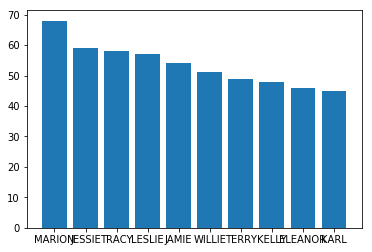

In [111]:
import pandas as pd
from matplotlib import pyplot as plt
d = pd.DataFrame([x.asDict() for x in top])
plt.bar(d.iloc[:,1], d.iloc[:,0])

In [26]:
df = df.cols.find('id').drop()

df\
    .cols.select('email').lower()\
    .cols.find('m').grid()

#     .cols('email').lower()\
#     .cols.select('email').lower()\
#     .cols.lower('email')\

#     .grid()
#df.select('payment_date','amount').columns

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

In [9]:
df = df.cols.find('name').df().rows.overwrite([('Nhập mật', 'khẩu')])
#   .rows.overwrite(['Nhập mật', 'khẩu'])\
#   .cols.apply(F.lower)\
#   .grid()

['first_name', 'last_name']

In [ ]:
import functools

def action(func):
    @functools.wraps(func)
    def wrapper_decorator(*args, **kwargs):
        # Do something before
        value = func(*args, **kwargs)
        print('pippo = ', value)
        return value
    return wrapper_decorator

@action
def plus(a, b):
    return a+b

plus(1, 2)

In [3]:
from bokeh.io import output_notebook
output_notebook()

Loading BokehJS ...

In [4]:
from bokeh.plotting import figure, show, output_file

output_file('hbar.html')

p = figure(plot_width=400, plot_height=400)
p.hbar(y=[1, 2, 3], height=0.5, left=0,
       right=[1.2, 2.5, 3.7], color="navy")

show(p)

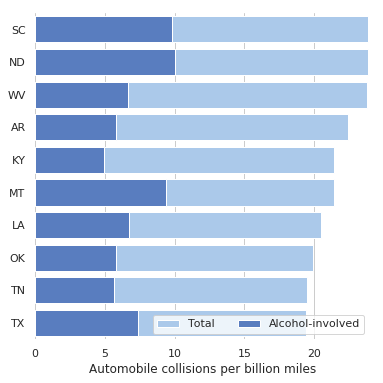

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="whitegrid")

# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(6, 6))

# Load the example car crash dataset
crashes = sns.load_dataset("car_crashes").sort_values("total", ascending=False)[:10]

# Plot the total crashes
sns.set_color_codes("pastel")
sns.barplot(x="total", y="abbrev", data=crashes,
            label="Total", color="b")

# Plot the crashes where alcohol was involved
sns.set_color_codes("muted")
sns.barplot(x="alcohol", y="abbrev", data=crashes,
            label="Alcohol-involved", color="b")

# Add a legend and informative axis label
ax.legend(ncol=2, loc="lower right", frameon=True)
ax.set(xlim=(0, 24), ylabel="",
       xlabel="Automobile collisions per billion miles")
sns.despine(left=True, bottom=True)

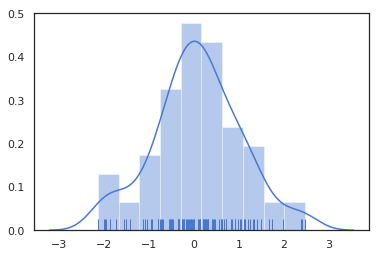

In [6]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="white", palette="muted", color_codes=True)

# Generate a random univariate dataset
rs = np.random.RandomState(10)
d = rs.normal(size=100)

# Plot a simple histogram with binsize determined automatically
sns.distplot(d, hist=True, kde=True, rug=True, color="b");

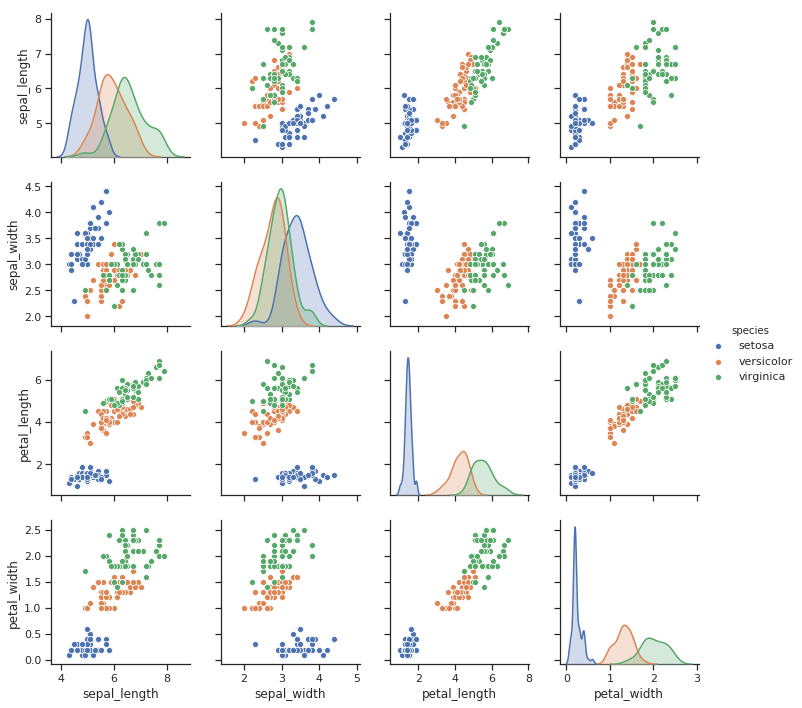

In [7]:
import seaborn as sns
sns.set(style="ticks")

df = sns.load_dataset("iris")
sns.pairplot(df, hue="species")

In [22]:
from IPython.display import HTML

HTML('''
    <!-- Bootstrap CSS -->
    <link rel="stylesheet" href="https://stackpath.bootstrapcdn.com/bootstrap/4.1.3/css/bootstrap.min.css" crossorigin="anonymous">
<div class="container-fluid">
<div class="jumbotron">
  <h1 class="display-4">Hello, world!</h1>
  <p class="lead">This is a simple hero unit, a simple jumbotron-style component for calling extra attention to featured content or information.</p>
  <hr class="my-4">
  <p>It uses utility classes for typography and spacing to space content out within the larger container.</p>
  <a class="btn btn-primary btn-lg" href="#" role="button">Learn more</a>
</div>
<button type="button" class="btn btn-secondary" data-toggle="tooltip" data-placement="top" title="Tooltip on top">
  Tooltip on top
</button>
<button type="button" class="btn btn-secondary" data-toggle="tooltip" data-placement="right" title="Tooltip on right">
  Tooltip on right
</button>
<button type="button" class="btn btn-secondary" data-toggle="tooltip" data-placement="bottom" title="Tooltip on bottom">
  Tooltip on bottom
</button>
<button type="button" class="btn btn-secondary" data-toggle="tooltip" data-placement="left" title="Tooltip on left">
  Tooltip on left
</button>
<table class="table">
  <thead>
    <tr>
      <th scope="col">#</th>
      <th scope="col">First</th>
      <th scope="col">Last</th>
      <th scope="col">Handle</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th scope="row">1</th>
      <td>Mark</td>
      <td>Otto</td>
      <td>@mdo</td>
    </tr>
    <tr>
      <th scope="row">2</th>
      <td>Jacob</td>
      <td>Thornton</td>
      <td>@fat</td>
    </tr>
    <tr>
      <th scope="row">3</th>
      <td>Larry</td>
      <td>the Bird</td>
      <td>@twitter</td>
    </tr>
  </tbody>
</table>
<span class="badge badge-primary">Primary</span>
<span class="badge badge-secondary">Secondary</span>
<span class="badge badge-success">Success</span>
<span class="badge badge-danger">Danger</span>
<span class="badge badge-warning">Warning</span>
<span class="badge badge-info">Info</span>
<span class="badge badge-light">Light</span>
<span class="badge badge-dark">Dark</span>
<table class="table table-sm" style="text-align:left">
  <thead>
    <tr>
      <th scope="col">#</th>
      <th scope="col">First</th>
      <th scope="col">Last</th>
      <th scope="col">Handle</th>
      <th scope="col">bar</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th scope="row">1</th>
      <td>Mark</td>
      <td>Otto</td>
      <td>@mdo</td>
      <td class="text-left"><span class="badge badge-primary" style="width: 75%">Primary</span></td>
    </tr>
    <tr>
      <th scope="row">2</th>
      <td>Jacob</td>
      <td>Thornton</td>
      <td>@fat</td>
      <td class="text-left"><span class="badge badge-secondary" style="width: 25%">Primary</span></td>
    </tr>
    <tr>
      <th scope="row">3</th>
      <td colspan="2">Larry the Bird</td>
      <td>@twitter</td>
      <td class="text-left"><span class="badge badge-warning" style="width: 55%">Primary</span></td>
</div>
    </tr>
  </tbody>
</table>
</div>''')

In [70]:
tbl = '''
<table class="table table-sm">
  <thead>
    <tr>
      <th scope="col">#</th>
      <th scope="col">First</th>
      <th scope="col">Last</th>
      <th scope="col">Handle</th>
      <th scope="col">bar</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th scope="row">1</th>
      <td>Mark</td>
      <td>Otto</td>
      <td>@mdo</td>
      <td class="text-left"><span class="badge badge-primary" style="width: 75%">75%</span></td>
    </tr>
    <tr>
      <th scope="row">2</th>
      <td>Jacob</td>
      <td>Thornton</td>
      <td>@fat</td>
      <td class="text-left"><span class="badge badge-secondary" style="width: 25%" title="Tooltip on top">25%</span></td>
    </tr>
    <tr>
      <th scope="row">3</th>
      <td colspan="2">Larry the Bird</td>
      <td>@twitter</td>
      <td class="text-left"><span class="badge badge-warning" style="width: 0%">0%</span></td>
    </tr>
  </tbody>
</table>
'''
drp = '''
<div class="dropdown">
  <button class="btn btn-secondary dropdown-toggle" type="button" id="dropdownMenuButton" data-toggle="dropdown" aria-haspopup="true" aria-expanded="false">
    Dropdown button
  </button>
  <div class="dropdown-menu" aria-labelledby="dropdownMenuButton">
    <a class="dropdown-item" href="#">Action</a>
    <a class="dropdown-item" href="#">Another action</a>
    <a class="dropdown-item" href="#">Something else here</a>
  </div>
</div>'''

tabs = f'''
<nav>
  <div class="nav nav-tabs" id="nav-tab" role="tablist">
    <a class="nav-item nav-link active" id="nav-home-tab" data-toggle="tab" href="#nav-home" role="tab" aria-controls="nav-home" aria-selected="true">Home</a>
    <a class="nav-item nav-link" id="nav-profile-tab" data-toggle="tab" href="#nav-profile" role="tab" aria-controls="nav-profile" aria-selected="false">Profile</a>
    <a class="nav-item nav-link" id="nav-contact-tab" data-toggle="tab" href="#nav-contact" role="tab" aria-controls="nav-contact" aria-selected="false">Contact</a>
  </div>
</nav>
<div class="tab-content" id="nav-tabContent">
  <div class="tab-pane fade show active" id="nav-home" role="tabpanel" aria-labelledby="nav-home-tab">..jjj.</div>
  <div class="tab-pane fade" id="nav-profile" role="tabpanel" aria-labelledby="nav-profile-tab">..kkk.</div>
  <div class="tab-pane fade" id="nav-contact" role="tabpanel" aria-labelledby="nav-contact-tab">{tbl}</div>
</div>
'''

from IPython.display import HTML

HTML(f'''
    <!-- Bootstrap CSS -->
    <link rel="stylesheet" href="https://stackpath.bootstrapcdn.com/bootstrap/4.1.3/css/bootstrap.min.css" crossorigin="anonymous">
    <div class="container-fluid">
        <div class="row">
            <div class="col">
            {drp}
            </div>
            <div class="col">
            
            {tabs}
            
            </div>
            <div class="col">
            {tbl}
            </div>  
        </div>
    </div>
    <script src="https://stackpath.bootstrapcdn.com/bootstrap/4.1.3/js/bootstrap.bundle.min.js" crossorigin="anonymous" >
''')

In [7]:
from IPython.display import HTML

HTML(f'''
    <!-- Bootstrap CSS -->
    <link rel="stylesheet" href="https://stackpath.bootstrapcdn.com/bootstrap/4.1.3/css/bootstrap.min.css" crossorigin="anonymous">
    <script src="https://stackpath.bootstrapcdn.com/bootstrap/4.1.3/js/bootstrap.bundle.min.js" crossorigin="anonymous" >
''')

In [30]:
d =df.cols.find('id', 'name').sample(10)
d.columns

AttributeError: 'function' object has no attribute 'sample'

In [29]:
tbl_head = '''
  <thead>
    <tr>
'''
tbl_head += '\n'.join(['      <th scope="col">'+str(x)+'</th>' for x in d.columns])

tbl_head +='''
    </tr>
  </thead>
'''

print(tbl_head)

tbl_body = '''
<tbody>
    <tr>
      <th scope="row">1</th>
      <td>Mark</td>
      <td>Otto</td>
      <td>@mdo</td>
      <td class="text-left"><span class="badge badge-primary" style="width: 75%">75%</span></td>
    </tr>
    <tr>
      <th scope="row">2</th>
      <td>Jacob</td>
      <td>Thornton</td>
      <td>@fat</td>
      <td class="text-left"><span class="badge badge-secondary" style="width: 25%" title="Tooltip on top">25%</span></td>
    </tr>
    <tr>
      <th scope="row">3</th>
      <td colspan="2">Larry the Bird</td>
      <td>@twitter</td>
      <td class="text-left"><span class="badge badge-warning" style="width: 0%">0%</span></td>
    </tr>
  </tbody>
</table>
'''

HTML(f'''
    <!-- Bootstrap CSS -->
    <div class="container-fluid">
        <div class="row">
            <div class="col">
            <table class="table table-sm">
                {tbl_head}
                {tbl_body}
            </table>
            </div>  
        </div>
    </div>
''')


  <thead>
    <tr>
      <th scope="col">rental_id</th>
      <th scope="col">staff_id</th>
      <th scope="col">customer_id</th>
      <th scope="col">store_id</th>
      <th scope="col">address_id</th>
      <th scope="col">first_name</th>
      <th scope="col">last_name</th>
    </tr>
  </thead>



In [58]:
# .rows.sample()
# .cols.select('name', 'id', 'amount')\
# .cols.apply(F.lower, 'name')\
# .cols.apply(F.floor, 'amount', output_prefix='_')\
# .cols.drop('^amount$')\
# .cols.rename()
# .cols.unicode()
.grid()

SyntaxError: invalid syntax (<ipython-input-58-a3008e300611>, line 8)

In [14]:
df = df.cols.select('name')
df = df.rows.overwrite([('Nhập mật', 'khẩu')])
df.columns
#   .rows.overwrite(['Nhập mật', 'khẩu'])\
#   .cols.apply(F.lower)\
#   .grid()
# #withColumn('pippo', F.lower(F.col('first_name'))).grid()

['first_name', 'last_name']

In [11]:
import pandas as pd

df = pd.DataFrame({'lab':['A', 'B', 'C'], 'val':[10, 30, 20]})
df.plot.bar(x='lab', y='val', rot=0);

In [8]:
from IPython.core.display import display, HTML
piece_size = 150
no_wrap_div = '<div style="padding:0; white-space: nowrap;">{}{}</div>'
display(HTML(no_wrap_div.format('<div style="display:inline-block; width:50%">hello</div>', '<div style="display:inline-block; width:50%">world</div>')))

In [71]:
!jupyter labextension install pylantern

> /opt/conda/bin/npm pack pylantern
pylantern-0.1.1.tgz
Incompatible extension:

"pylantern@0.1.1" is not compatible with the current JupyterLab
Conflicting Dependencies:
JupyterLab              Extension        Package
>=0.18.2 <0.19.0        >=0.19.0 <0.20.0 @jupyterlab/application
>=0.18.2 <0.19.0        >=0.19.0 <0.20.0 @jupyterlab/apputils
>=0.18.2 <0.19.0        >=0.19.0 <0.20.0 @jupyterlab/notebook
>=0.18.2 <0.19.0        >=0.19.0 <0.20.0 @jupyterlab/rendermime

Found compatible version: 0.1.0
> /opt/conda/bin/npm pack pylantern@0.1.0
pylantern-0.1.0.tgz
> node /opt/conda/lib/python3.6/site-packages/jupyterlab/staging/yarn.js install
yarn install v1.9.4
info No lockfile found.
[1/4] Resolving packages...
⠁ ⠂ @jupyterlab/application@^0.18.2⠄ @jupyterlab/application@^0.18.2⡀ @jupyterlab/application@^0.18.2⢀ @jupyterlab/application@^0.18.2⠠ @jupyterlab/application@^0.18.2⠐ @jupyterlab/application@^0.18.2⠈ @jupyterlab/application@^0.18.2⠁ @jupyterlab/application@^0.18.2⠂ @jupyterlab

In [72]:
!pip install pylantern

    100% |████████████████████████████████| 81kB 825kB/s 
    100% |████████████████████████████████| 880kB 415kB/s 
    100% |████████████████████████████████| 3.0MB 158kB/s 
    100% |████████████████████████████████| 1.2MB 301kB/s 
    100% |████████████████████████████████| 2.3MB 223kB/s 
    100% |████████████████████████████████| 41.5MB 12kB/s 
    100% |████████████████████████████████| 13.1MB 49kB/s 
    100% |████████████████████████████████| 204kB 1.7MB/s 
    100% |████████████████████████████████| 194kB 2.6MB/s 
    100% |████████████████████████████████| 81kB 2.3MB/s 
  Running setup.py bdist_wheel for pylantern ... error
  Complete output from command /opt/conda/bin/python -u -c "import setuptools, tokenize;__file__='/tmp/pip-build-havd3uzc/pylantern/setup.py';f=getattr(tokenize, 'open', open)(__file__);code=f.read().replace('\r\n', '\n');f.close();exec(compile(code, __file__, 'exec'))" bdist_wheel -d /tmp/tmpui55gh05pip-wheel- --python-tag cp36:
  running bdist_wheel
  r

In [77]:
!pip install lineup

    100% |████████████████████████████████| 51kB 695kB/s 
    Complete output from command python setup.py egg_info:
    Traceback (most recent call last):
      File "<string>", line 1, in <module>
      File "/tmp/pip-build-_g7_dhdo/milieu/setup.py", line 109
        print '>> Nothing to do'
                               ^
    SyntaxError: Missing parentheses in call to 'print'. Did you mean print(print '>> Nothing to do')?
    
    ----------------------------------------
Command "python setup.py egg_info" failed with error code 1 in /tmp/pip-build-_g7_dhdo/milieu/
You are using pip version 9.0.3, however version 19.1.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [81]:
!pip install pixiedust

In [89]:
import pixiedust

pixiedust.display(df)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [85]:
import lantern as lt

df  = lt.bar()
lt.grid(df, 'qgrid')

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

In [119]:
from pyspark.sql import types as T
from pyspark.sql import functions as F

In [23]:
import unidecode as ud
import pyspark.sql.utils

def _unidecode(s):
    return s if not s else ud.unidecode(s)

try:
    import pyarrow
    import pandas
    
    @F.pandas_udf(T.StringType(), F.PandasUDFType.SCALAR)
    def unidecode(series):
        return series.apply(_unidecode(s))
    
except ImportError:
    @F.udf(T.StringType(), T.StringType())
    def unidecode(s):
        return _unidecode(s)

df.cols.apply(unidecode).grid()

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

In [21]:
!cat /opt/spark/python/pyspark/sql/utils.py

#
# Licensed to the Apache Software Foundation (ASF) under one or more
# contributor license agreements.  See the NOTICE file distributed with
# this work for additional information regarding copyright ownership.
# The ASF licenses this file to You under the Apache License, Version 2.0
# (the "License"); you may not use this file except in compliance with
# the License.  You may obtain a copy of the License at
#
#    http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
#

import py4j


class CapturedException(Exception):
    def __init__(self, desc, stackTrace):
        self.desc = desc
        self.stackTrace = stackTrace

    def __str__(self):
        return repr(self.desc)


clas

In [12]:
import datalabframework as dlf

IndentationError: expected an indented block (cols.py, line 25)

In [123]:
class A:
    def __init__(self):
        self.columns = ['a', 'b', 'c']

from functools import wraps

def add_method(cls):
    return add_attr(cls)

def add_attr(cls):
    def decorator(func):
        @wraps(func)
        def wrapper(*args, **kwargs):
            f = func(*args, **kwargs)
            return f
        setattr(cls, func.__name__, wrapper)
    return decorator

def add_prop(cls):
    def decorator(func):
        @wraps(func)
        def wrapper(*args, **kwargs):
            f = func(*args, **kwargs)
        property(cls, func.__name__, wrapper)
        return func
    return decorator


def cols(self):

#     @property
#     def g(self):
#         print("Getting value")
#         return _selected

#     @g.setter
#     def s(self, v=None):
#         _selected = v

#     _selected = property(g)
    
    @add_attr(cols)
    def t(v=None):
        if v is not None:
            cols.v = v
        return  cols.v

    return cols

cols.v = None

A.cols  = property(cols)
A.cols = None


1 1 10


10

In [126]:
a= A()
a.cols.v = 5
b=A()
b.cols.v = 8
a.cols.t(), b.cols.t()

(8, 8)

In [80]:
a.cols.g

AttributeError: 'function' object has no attribute 'g'